In [4]:
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import torch.nn as nn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Preparation of Data for Training

In [5]:
import requests

url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
output_path = "mnist-original.mat"

response = requests.get(url, stream=True)
response.raise_for_status()  # Raise an exception for bad status codes
with open(output_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        f.write(chunk)

print(f"Downloaded {output_path}")

Downloaded mnist-original.mat


In [6]:
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

In [7]:
def poisson_spike_encoding(images, time_steps=100):
    return (np.random.rand(images.shape[0], time_steps, 784) < images[:, None, :]).astype(np.uint8)


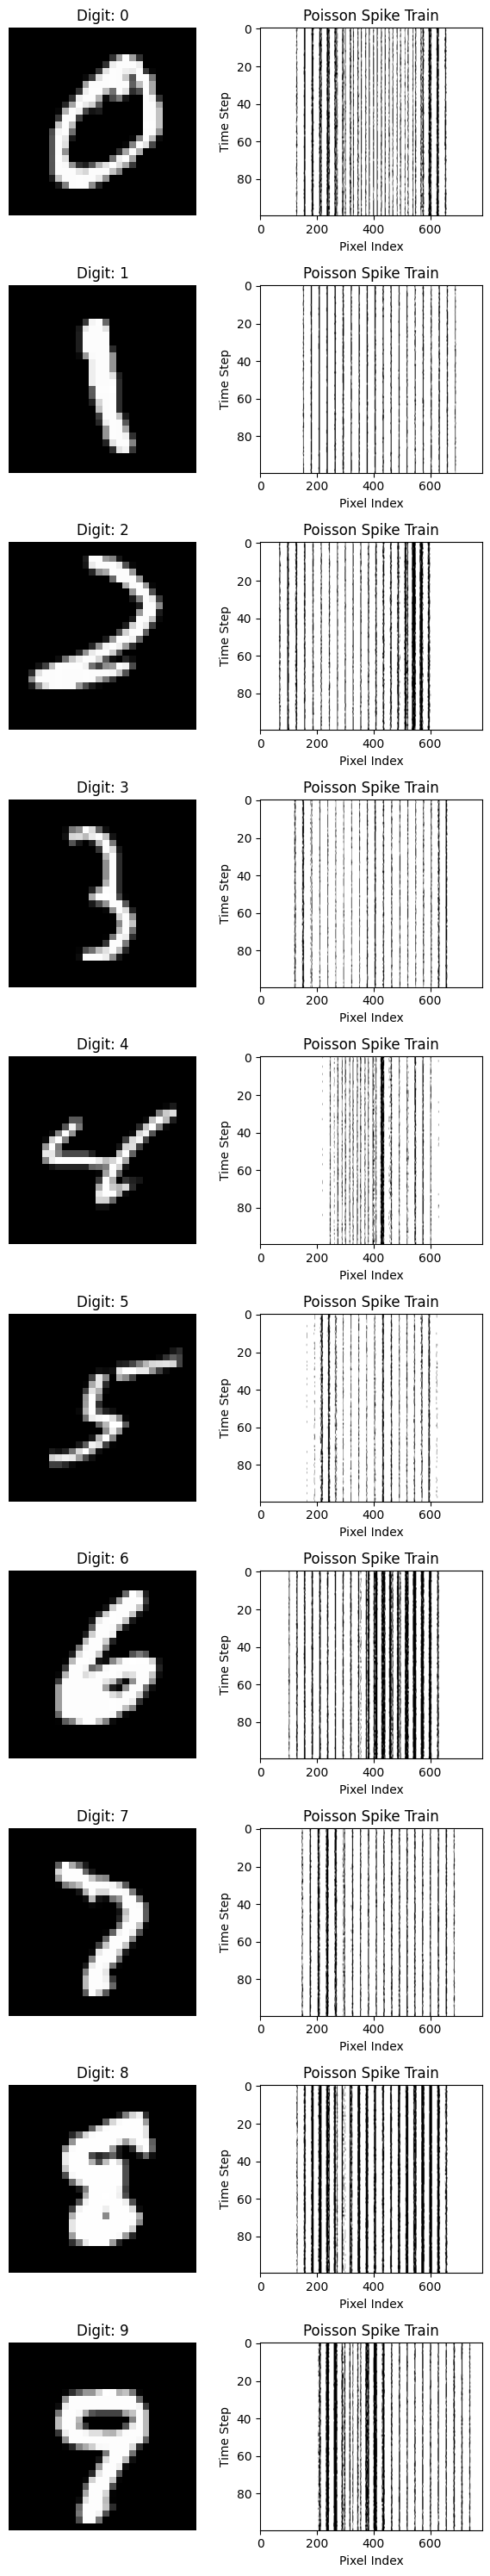

In [8]:
# Choose 3 indices
indices = [0, 7000, 14000, 21000, 28000, 35000, 66987, 42000, 49000, 56000]
images = mnist_data[indices]/255.0  # shape: (3, 784)
labels = mnist_label[indices]  # shape: (3,)

spike_trains = poisson_spike_encoding(images, time_steps=100)  # shape: (3, 100, 784)

# Plotting
plt.figure(figsize=(6, 30))

for i in range(10):
    # Digit image
    plt.subplot(10, 2, 2*i + 1)
    plt.imshow(images[i].reshape(28, 28), cmap="gray")
    plt.title(f"Digit: {int(labels[i])}")
    plt.axis("off")

    # Spike train
    plt.subplot(10, 2, 2*i + 2)
    plt.imshow(spike_trains[i], cmap="Greys", aspect="auto")
    plt.title("Poisson Spike Train")
    plt.xlabel("Pixel Index")
    plt.ylabel("Time Step")

plt.tight_layout()
plt.show()



In [9]:
output_dir = "spike_mnist_dataset"
os.makedirs(output_dir, exist_ok=True)

time_steps = 100
chunk_size = 1000
num_samples = mnist_data.shape[0]  # 70,000
input_dim = 784

# Preallocate space on disk
spike_path = os.path.join(output_dir, f"spike_trains_{time_steps}ts.npy")
label_path = os.path.join(output_dir, "labels.npy")

spike_memmap = np.memmap(spike_path, dtype=np.uint8, mode='w+', shape=(num_samples, time_steps, input_dim))
label_memmap = np.memmap(label_path, dtype=np.uint8, mode='w+', shape=(num_samples,))

print("Encoding and saving...")

for i in tqdm(range(0, num_samples, chunk_size)):
    chunk = mnist_data[i:i+chunk_size] / 255.0
    label_chunk = mnist_label[i:i+chunk_size]

    spike_chunk = poisson_spike_encoding(chunk, time_steps).astype(np.uint8)

    spike_memmap[i:i+chunk_size] = spike_chunk
    label_memmap[i:i+chunk_size] = label_chunk

# Flush data to disk
spike_memmap.flush()
label_memmap.flush()

print("All spike data encoded and saved!!")

Encoding and saving...


100%|██████████| 70/70 [01:16<00:00,  1.09s/it]


All spike data encoded and saved!!


In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpikeMNISTDataset(Dataset):
    def __init__(self, spike_file, label_file):
        self.spikes = np.memmap(spike_file, dtype=np.uint8, mode="r", shape=(70000, 100, 784))
        self.labels = np.memmap(label_file, dtype=np.uint8, mode="r", shape=(70000,))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        spike_tensor = torch.tensor(self.spikes[idx], dtype=torch.float32)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return spike_tensor, label_tensor


In [11]:
from torch.utils.data import DataLoader, random_split

dataset = SpikeMNISTDataset("spike_mnist_dataset/spike_trains_100ts.npy",
                             "spike_mnist_dataset/labels.npy")

# Set lengths
train_len = 60000
test_len = len(dataset) - train_len


generator = torch.Generator().manual_seed(42)


train_dataset, test_dataset = random_split(dataset, [train_len, test_len], generator=generator)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


## Making of Neuron Model

In [12]:
class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, threshold):
        ctx.save_for_backward(input - threshold)
        return (input >= threshold).float()

    @staticmethod
    def backward(ctx, grad_output):
        (x,) = ctx.saved_tensors
        beta = 10.0
        grad = beta * torch.exp(-beta * x.abs()) / ((1 + torch.exp(-beta * x.abs())) ** 2)
        return grad_output * grad, None

In [13]:
def spike_fn(input, threshold=1.0):
    return SurrogateSpike.apply(input, threshold)

In [14]:
class LIFNeuron(nn.Module):
    def __init__(self, size, threshold=1.0, tau=2.0):
        super().__init__()
        self.V = None  # initialized later
        self.threshold = threshold
        self.alpha = torch.exp(torch.tensor(-1.0 / tau))
        self.size = size

    def reset(self):
        self.V = None

    def forward(self, input):
        if self.V is None or self.V.shape != input.shape:
            self.V = torch.zeros_like(input)

        # Leaky integration
        self.V = self.alpha * self.V + input

        # Spike generation using surrogate
        S = spike_fn(self.V, self.threshold)


        self.V = self.V * (1 - S)

        return S

In [15]:
class SNNLayer(nn.Module):
    def __init__(self, in_dim, out_dim, threshold=1.0, tau=2.0):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.neuron = LIFNeuron(size=out_dim, threshold=threshold, tau=tau)

    def forward(self, input_spikes):
        I = self.linear(input_spikes)
        return self.neuron(I)

In [16]:
class SNNModel(nn.Module):
    def __init__(self, input_size=784, hidden_size=256, output_size=10, time_steps=100):
        super().__init__()
        self.time_steps = time_steps
        self.layer1 = SNNLayer(input_size, hidden_size)
        self.layer2 = SNNLayer(hidden_size, output_size)

    def reset(self):
        self.layer1.neuron.reset()
        self.layer2.neuron.reset()

    def forward(self, x):
        batch_size = x.size(0)
        output_spike_count = torch.zeros((batch_size, 10), device=x.device)

        for t in range(self.time_steps):
            input_t = x[:, t, :]
            spikes_hidden = self.layer1(input_t)
            spikes_out = self.layer2(spikes_hidden)
            output_spike_count += spikes_out

        return output_spike_count


## Training

In [17]:
model = SNNModel(time_steps=100).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train_step(batch_spikes, batch_labels):
    batch_spikes = batch_spikes.to("cuda").float()
    batch_labels = batch_labels.to("cuda")

    optimizer.zero_grad()
    model.reset()  # ← ensures no memory leak in neuron state
    out = model(batch_spikes)
    loss = criterion(out, batch_labels)
    loss.backward()
    optimizer.step()


    preds = out.argmax(dim=1)
    correct = (preds == batch_labels).sum().item()
    total_correct = correct
    total_samples = batch_labels.size(0)

    return loss.item(), total_correct, total_samples

In [18]:
num_epochs=10

batch_losses = []
batch_accuracies = []


for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_spikes, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        loss, correct, samples = train_step(batch_spikes, batch_labels)
        total_loss += loss
        total_correct += correct
        total_samples += samples
        batch_losses.append(loss)
        batch_accuracies.append(correct*100/ samples)

    acc = total_correct / total_samples * 100
    avg_loss = total_loss / len(train_loader)


    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {acc:.2f}%")



Epoch 1: 100%|██████████| 1875/1875 [04:07<00:00,  7.57it/s]


Epoch 1 | Loss: 0.7958 | Accuracy: 81.91%


Epoch 2: 100%|██████████| 1875/1875 [04:06<00:00,  7.61it/s]


Epoch 2 | Loss: 0.3291 | Accuracy: 93.11%


Epoch 3: 100%|██████████| 1875/1875 [04:06<00:00,  7.60it/s]


Epoch 3 | Loss: 0.2359 | Accuracy: 94.81%


Epoch 4: 100%|██████████| 1875/1875 [04:04<00:00,  7.67it/s]


Epoch 4 | Loss: 0.1733 | Accuracy: 95.91%


Epoch 5: 100%|██████████| 1875/1875 [04:02<00:00,  7.73it/s]


Epoch 5 | Loss: 0.1301 | Accuracy: 96.59%


Epoch 6: 100%|██████████| 1875/1875 [04:01<00:00,  7.76it/s]


Epoch 6 | Loss: 0.1078 | Accuracy: 97.12%


Epoch 7: 100%|██████████| 1875/1875 [04:00<00:00,  7.81it/s]


Epoch 7 | Loss: 0.0877 | Accuracy: 97.54%


Epoch 8: 100%|██████████| 1875/1875 [04:01<00:00,  7.77it/s]


Epoch 8 | Loss: 0.0692 | Accuracy: 97.93%


Epoch 9: 100%|██████████| 1875/1875 [03:58<00:00,  7.85it/s]


Epoch 9 | Loss: 0.0572 | Accuracy: 98.31%


Epoch 10: 100%|██████████| 1875/1875 [03:58<00:00,  7.85it/s]

Epoch 10 | Loss: 0.0497 | Accuracy: 98.48%


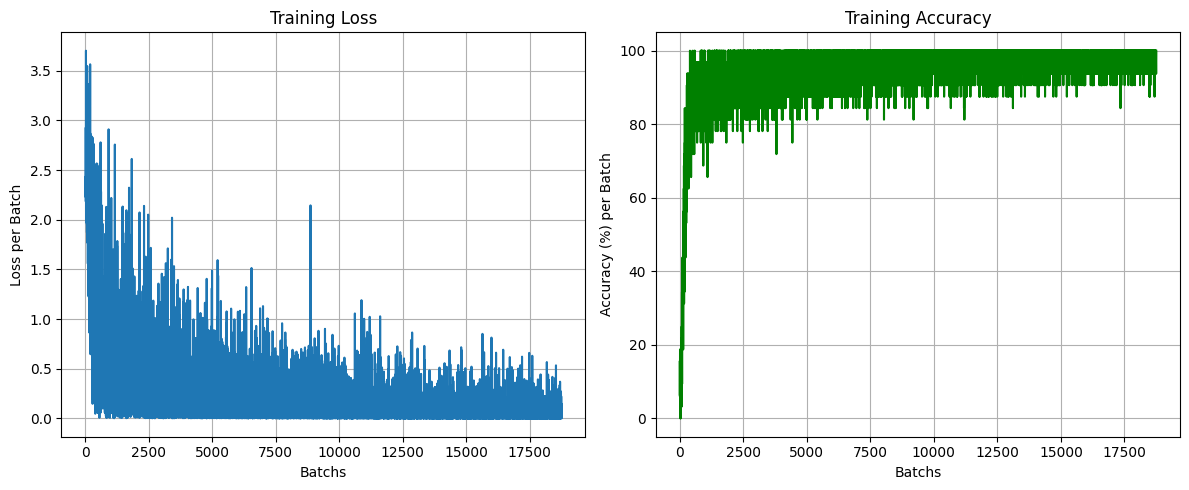

In [19]:
batches = list(range(1,len(batch_losses)+1))

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(batches, batch_losses)
plt.title("Training Loss")
plt.xlabel("Batchs")
plt.ylabel("Loss per Batch")
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(batches, batch_accuracies, color='green')
plt.title("Training Accuracy")
plt.xlabel("Batchs")
plt.ylabel("Accuracy (%) per Batch")
plt.grid(True)

plt.tight_layout()
plt.savefig("snn_training_results.png")
plt.show()

## Testing

100%|██████████| 313/313 [00:16<00:00, 19.02it/s]



Final Test Accuracy: 96.49% on 10000 samples


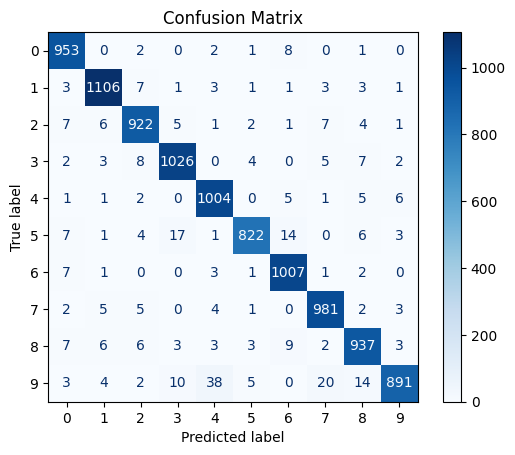

In [20]:
@torch.no_grad()

def evaluate_model(model, test_loader):
    model.eval()
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []
    size=len(test_loader)

    for i, (spikes, labels) in tqdm(enumerate(test_loader),total=len(test_loader)):

        spikes = spikes.to("cuda").float()
        labels = labels.to("cuda")

        out = model(spikes)
        preds = out.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    acc = total_correct / total_samples * 100
    print(f"\nFinal Test Accuracy: {acc:.2f}% on {total_samples} samples")


    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.savefig("Confusion_Matrix.png")
    plt.show()


evaluate_model(model, test_loader)
